## <center> Sentimental Analysis using Deep Learning </center>



In [ ]:
import os
import numpy as np
import pandas as pd
import json
import logging
import time
from pathlib import Path
from datetime import datetime

import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.optim import AdamW
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)
from sklearn.metrics import accuracy_score, f1_score
import wandb

# Data Visulization

In [ ]:
# Stanford Sentiment Treebank overview
sst_df = pd.read_csv(SST_FILE)
if sst_df is not None:
    print("\n--- Stanford Sentiment Treebank Overview ---")
    print(f"Shape: {sst_df.shape}")
    print("\nColumns:")
    for col in sst_df.columns:
        print(f"- {col}: {sst_df[col].dtype}")

    print("\nSample rows:")
    display(sst_df.head())


--- Stanford Sentiment Treebank Overview ---
Shape: (11855, 2)

Columns:
- text: object
- label: int64

Sample rows:


,text,label
0,The Rock is destined to be the 21st Century 's...,1
1,The gorgeously elaborate continuation of `` Th...,1
2,Effective but too-tepid biopic,1
3,If you sometimes like to go to the movies to h...,1
4,"Emerges as something rare , an issue movie tha...",0


In [ ]:
# SMNBC dataset overview
smnbc_df = pd.read_csv(SMNBC_FILE)
if smnbc_df is not None:
    print("\n--- SMNBC Dataset Overview ---")
    print(f"Shape: {smnbc_df.shape}")
    print("\nColumns:")
    for col in smnbc_df.columns:
        print(f"- {col}: {smnbc_df[col].dtype}")
    print("\nSample rows:")
    display(smnbc_df.head())


--- SMNBC Dataset Overview ---
Shape: (10751, 2)

Columns:
- text: object
- label: float64

Sample rows:


,text,label
0,You can connect to the world but become irrele...,0.0
1,internet and social media keeps us updated,2.0
2,There are many activities on social media whic...,2.0
3,Some activities have more negative influences,0.0
4,Everyone gets information,2.0


In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud
# Function to create a word cloud
def create_wordcloud(df, text_col='text', title=''):
    # Handle NaN values and convert all to string
    text = ' '.join(df[text_col].fillna('').astype(str))

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        max_words=100,
        contour_width=3
    ).generate(text)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {title}', fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
def get_top_words_by_sentiment(df, text_col='text', label_col='label', n=20):
    stop_words = set(stopwords.words('english'))

    # Add some common words to stop words
    extra_stop_words = {'s', 't', 've', 'll', 're', 'm', 'd', 'em', 'just', 'get', 'also', 'go', 'would', 'could'}
    stop_words.update(extra_stop_words)

    # Initialize CountVectorizer
    from sklearn.feature_extraction.text import CountVectorizer # Import CountVectorizer
    vectorizer = CountVectorizer(
        max_features=10000,
        stop_words=list(stop_words),
        token_pattern=r'\b[a-zA-Z][a-zA-Z]{2,}\b'  # At least 3 chars, starting with letter
    )

    # Ensure text column is string and handle NaNs
    df[text_col] = df[text_col].fillna('').astype(str)

    X = vectorizer.fit_transform(df[text_col])
    words = vectorizer.get_feature_names_out()

    # Group by sentiment and get top words
    top_words_by_sentiment = {}
    # Handle potential NaN labels by dropping them before getting unique labels
    unique_labels = df[label_col].dropna().unique()

    for label in sorted(unique_labels): # Sort labels to ensure consistent plotting order
        label_indices = df[df[label_col] == label].index
        label_counts = X[label_indices].sum(axis=0)
        label_word_counts = [(words[i], label_counts[0, i]) for i in range(len(words))]
        label_word_counts = sorted(label_word_counts, key=lambda x: x[1], reverse=True)
        top_words_by_sentiment[label] = label_word_counts[:n]

    # Plot top words by sentiment
    num_labels = len(unique_labels)
    # Adjust figure size based on the number of labels to avoid overlap
    fig, axes = plt.subplots(1, num_labels, figsize=(5 * num_labels, 6))

    # Ensure axes is an array even for a single subplot
    if num_labels == 1:
        axes = [axes]

    for i, label in enumerate(sorted(unique_labels)): # Sort labels for consistent subplot order
        ax = axes[i]
        if top_words_by_sentiment[label]: # Check if there are words for the label
            words, counts = zip(*top_words_by_sentiment[label])

            y_pos = np.arange(len(words))
            ax.barh(y_pos, counts)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(words)
            ax.invert_yaxis()  # Labels read top-to-bottom
            ax.set_title(f'Top Words for Label: {label}')
        else:
             ax.set_title(f'No words for Label: {label}')
             ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


    plt.tight_layout()
    plt.show()

    return top_words_by_sentiment

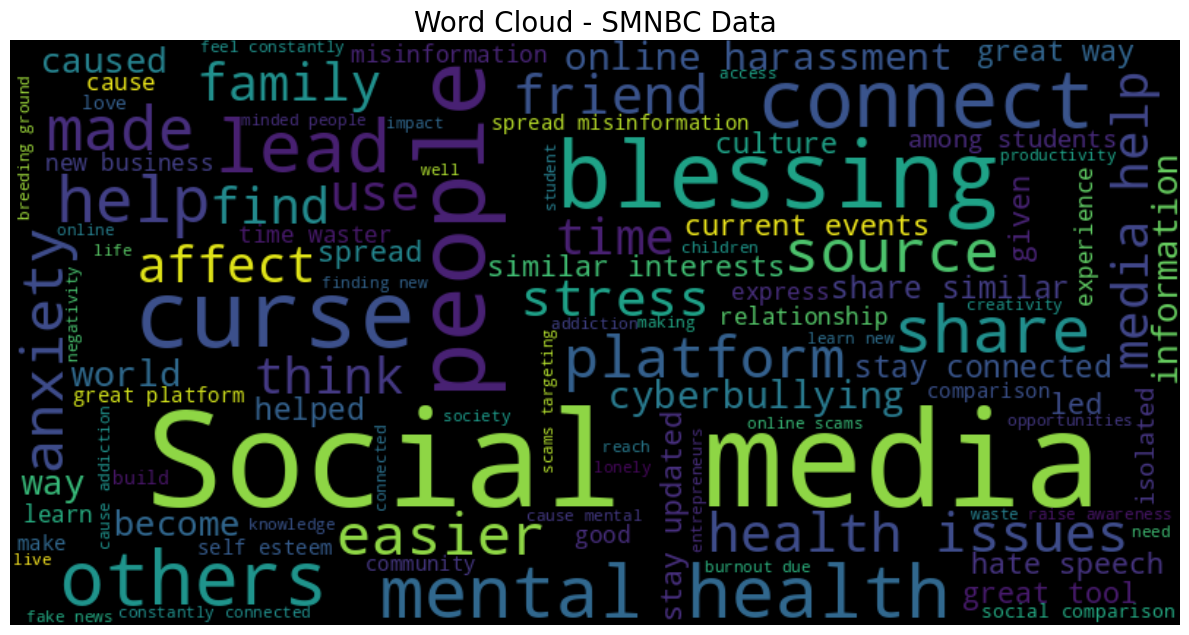

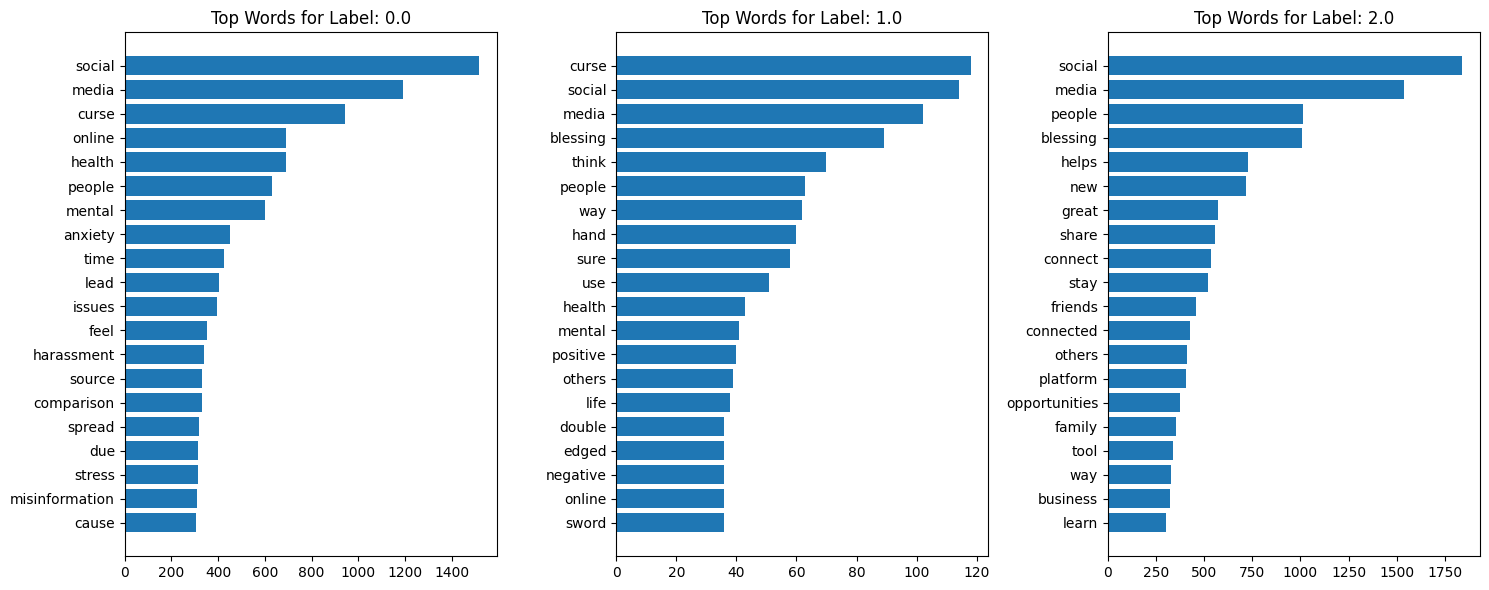

In [ ]:
if smnbc_df is not None:
    create_wordcloud(smnbc_df, title="SMNBC Data")
    top_words_reddit = get_top_words_by_sentiment(smnbc_df)

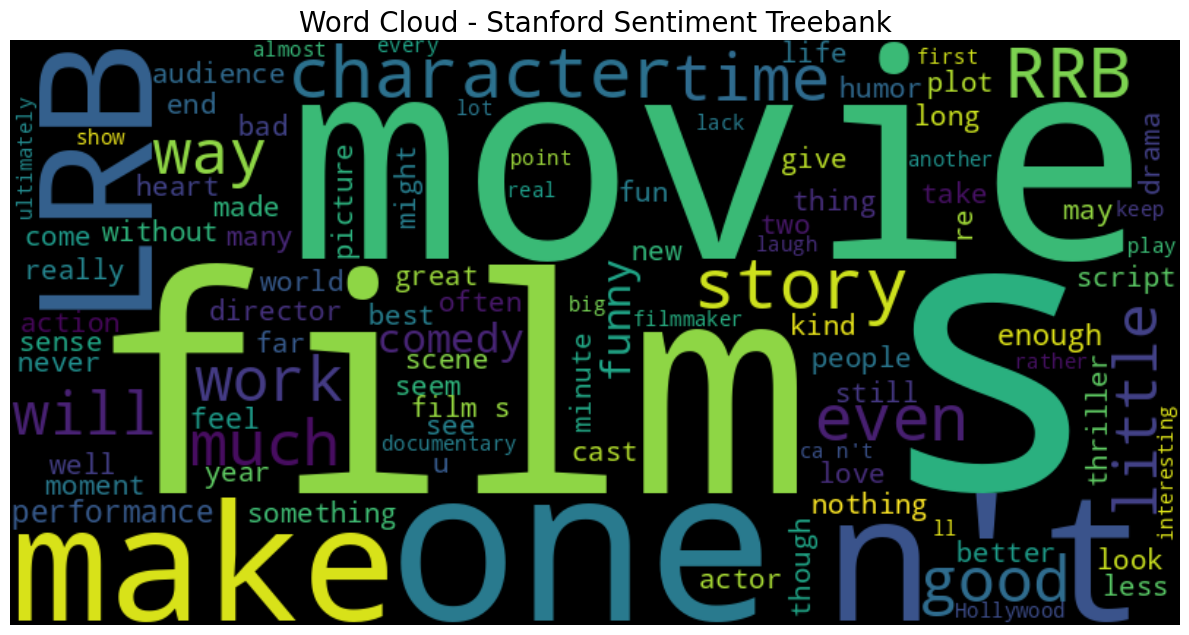

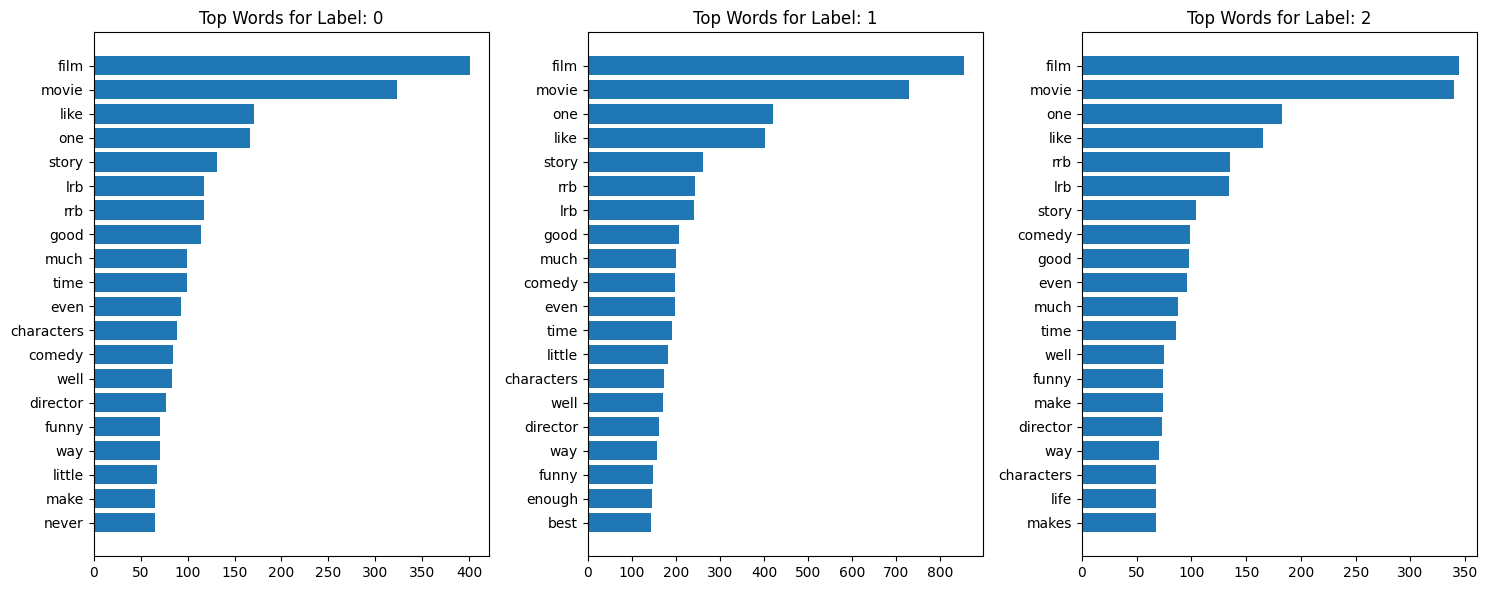

In [ ]:
# Create word clouds
if sst_df is not None:
    create_wordcloud(sst_df, title="Stanford Sentiment Treebank")
    top_words_sst = get_top_words_by_sentiment(sst_df)

Label Distribution Analysis

In [ ]:
# Function to plot label distribution
def plot_label_distribution(df, title, label_col='label'):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=label_col, data=df)

    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'bottom',
                    xytext = (0, 5), textcoords = 'offset points')

    plt.title(f'Label Distribution - {title}')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Print percentage distribution
    value_counts = df[label_col].value_counts(normalize=True) * 100
    print(f"\nPercentage Distribution - {title}:")
    for label, pct in value_counts.items():
        print(f"- {label}: {pct:.2f}%")

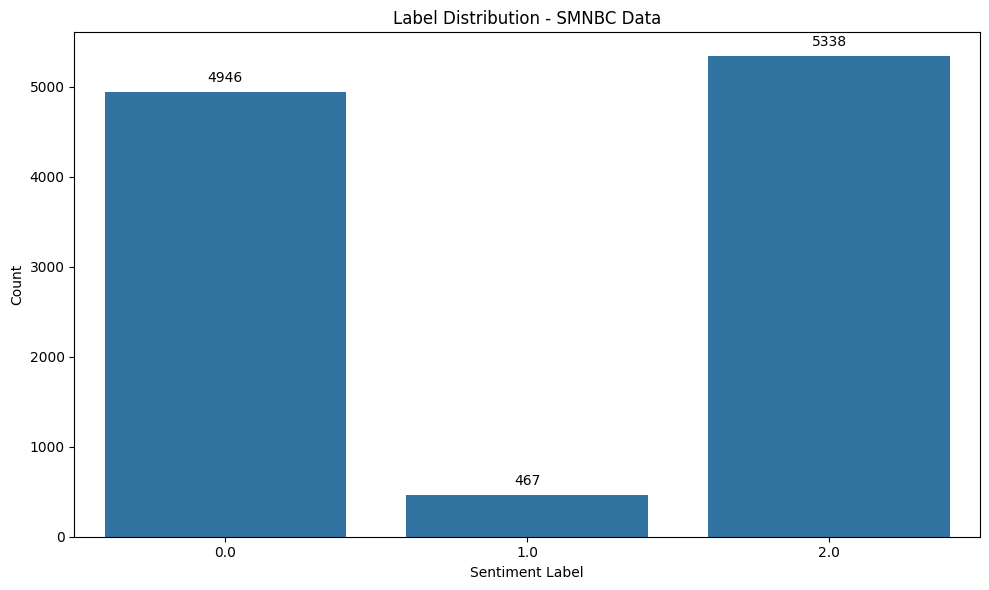


Percentage Distribution - SMNBC Data:
- 2.0: 49.65%
- 0.0: 46.01%
- 1.0: 4.34%


In [ ]:
# Plot label distribution for Reddit
if smnbc_df is not None:
    plot_label_distribution(smnbc_df, "SMNBC Data")

Text Length Analysis

In [ ]:
def analyze_text_length(df, text_col='text', title=''):
    # Calculate text length with null/float handling
    df['text_length'] = df[text_col].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

    # Plot histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(df['text_length'], bins=50, kde=True)

    # Add vertical lines for mean and median
    mean_length = df['text_length'].mean()
    median_length = df['text_length'].median()

    plt.axvline(mean_length, color='r', linestyle='-', alpha=0.7,
               label=f"Mean: {mean_length:.1f}")
    plt.axvline(median_length, color='g', linestyle='--', alpha=0.7,
               label=f"Median: {median_length:.1f}")

    plt.title(f'Text Length Distribution - {title}')
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Frequency')
    plt.legend()

    # Add text length stats
    print(f"\nText Length Statistics - {title}:")
    print(f"Min: {df['text_length'].min()}")
    print(f"Max: {df['text_length'].max()}")
    print(f"Mean: {mean_length:.2f}")
    print(f"Median: {median_length:.2f}")
    print(f"Std Dev: {df['text_length'].std():.2f}")

    # Plot text length by sentiment
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='label', y='text_length', data=df)
    plt.title(f'Text Length by Sentiment - {title}')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Text Length (characters)')
    plt.tight_layout()


Text Length Statistics - SMNBC Data:
Min: 4
Max: 752
Mean: 81.16
Median: 72.00
Std Dev: 61.42


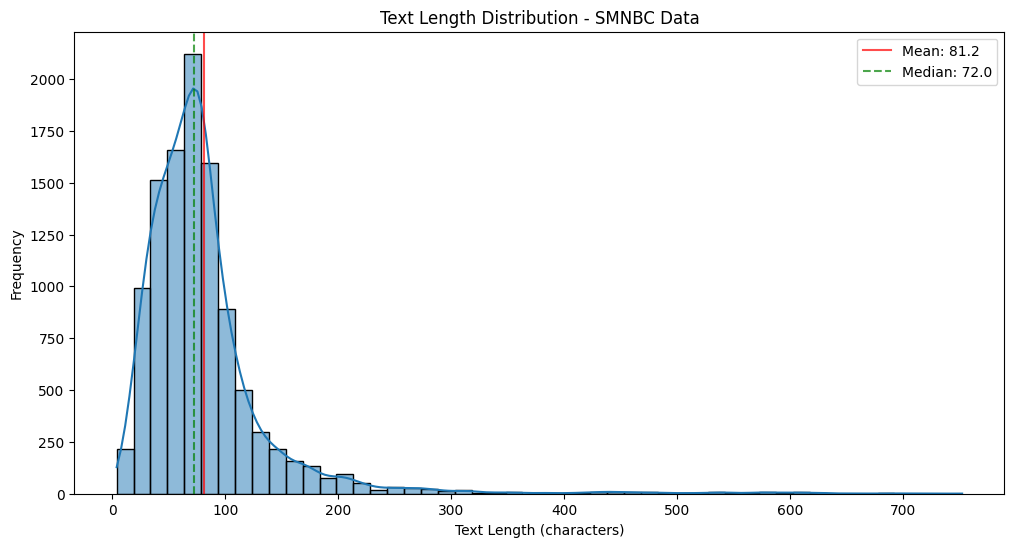

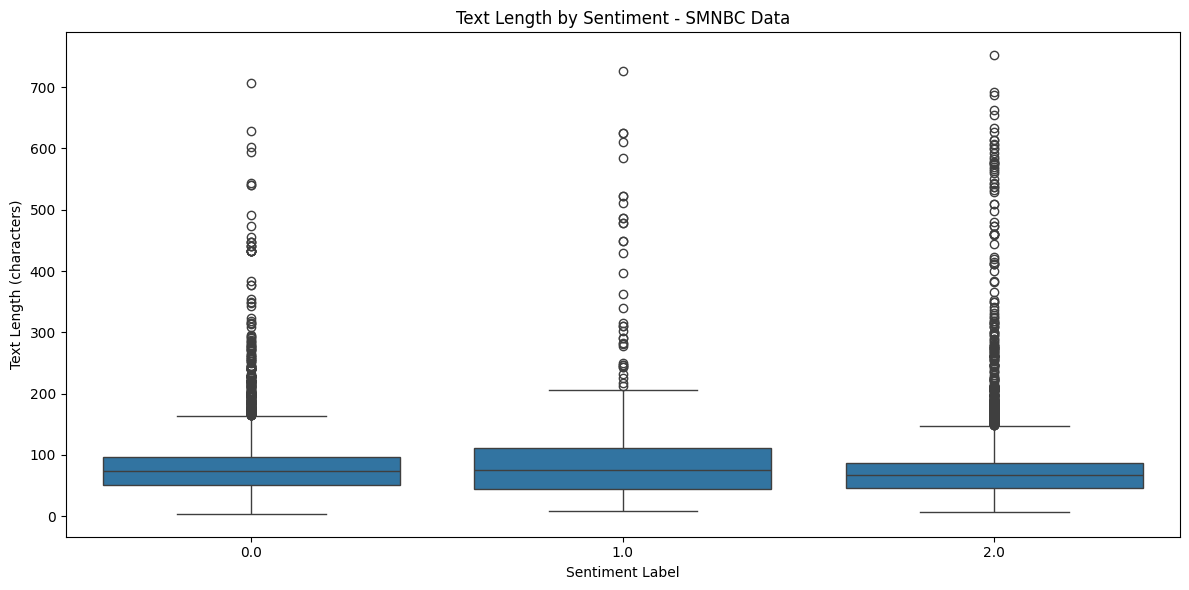

In [ ]:
# Analyze text length for SMNBC
if smnbc_df is not None:
    analyze_text_length(smnbc_df, title="SMNBC Data")

## Model Trainning

In [ ]:
# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define paths
PROCESSED_DATA_DIR = Path("/content/drive/MyDrive/Dataset/Processed/")
MODELS_DIR = Path("/content/drive/MyDrive/ModelDir")
RESULTS_DIR = Path("/content/drive/MyDrive/ResultDir")

# Ensure directories exist
MODELS_DIR.mkdir(exist_ok=True, parents=True)
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

class ModelTrainer:
    def __init__(self, model_type, model_name, dataset_name, pretrained_model=None, num_labels=3, device=None):
        self.model_type = model_type
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.num_labels = num_labels

        if pretrained_model is None:
            if model_type == 'xlnet':
                self.pretrained_model = 'xlnet/xlnet-base-cased'
            elif model_type == 'siebert':
                self.pretrained_model = 'siebert/sentiment-roberta-large-english'
            else:
                self.pretrained_model = model_type
        else:
            self.pretrained_model = pretrained_model

        self.device = torch.device(device) if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        logger.info(f"Training {model_type}/{model_name} on {dataset_name} dataset using {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(self.pretrained_model)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.pretrained_model, num_labels=num_labels
        ).to(self.device)

        self.output_dir = MODELS_DIR / model_type / model_name
        self.output_dir.mkdir(exist_ok=True, parents=True)

        self.train_stats = {
            'model_type': model_type,
            'model_name': model_name,
            'dataset': dataset_name,
            'pretrained_model': self.pretrained_model,
            'num_labels': num_labels,
            'training_started': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'epochs': [],
            'training_time': None
        }

    def prepare_data(self, batch_size=16, max_length=128):
        train_df = pd.read_csv(PROCESSED_DATA_DIR / f"{self.dataset_name}_train.csv")
        val_df = pd.read_csv(PROCESSED_DATA_DIR / f"{self.dataset_name}_val.csv")

        logger.info(f"Loaded {len(train_df)} training and {len(val_df)} validation samples")

        train_texts, val_texts = train_df['processed_text'].tolist(), val_df['processed_text'].tolist()
        train_labels, val_labels = train_df['label'].tolist(), val_df['label'].tolist()

        if not isinstance(train_labels[0], (int, float, np.number)):
            unique_labels = sorted(set(train_labels + val_labels))
            self.label_map = {label: i for i, label in enumerate(unique_labels)}
            train_labels = [self.label_map[label] for label in train_labels]
            val_labels = [self.label_map[label] for label in val_labels]
            with open(self.output_dir / "label_map.json", "w") as f:
                json.dump(self.label_map, f, indent=2)

        train_enc = self.tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
        val_enc = self.tokenizer(val_texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')

        train_dataset = TensorDataset(train_enc['input_ids'], train_enc['attention_mask'], torch.tensor(train_labels, dtype=torch.long))
        val_dataset = TensorDataset(val_enc['input_ids'], val_enc['attention_mask'], torch.tensor(val_labels, dtype=torch.long))

        train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

        return train_dataloader, val_dataloader

    def train(self, epochs=4, batch_size=16, learning_rate=2e-5, max_length=128,
              weight_decay=0.01, warmup_steps=0, save_every_epoch=True):

        train_dataloader, val_dataloader = self.prepare_data(batch_size, max_length)

        wandb.init(
            project="sentiment-analysis",
            name=f"{self.model_type}-{self.model_name}",
            config={
                "model_type": self.model_type,
                "model_name": self.model_name,
                "dataset": self.dataset_name,
                "pretrained_model": self.pretrained_model,
                "epochs": epochs,
                "batch_size": batch_size,
                "learning_rate": learning_rate,
                "max_length": max_length,
                "weight_decay": weight_decay,
                "warmup_steps": warmup_steps,
                "num_labels": self.num_labels
            }
        )
        wandb.watch(self.model)

        optimizer = AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

        best_val_f1 = 0.0
        start_time = time.time()

        for epoch in range(epochs):
            logger.info(f"Epoch {epoch + 1}/{epochs}")
            self.model.train()
            train_loss = 0

            for step, batch in enumerate(train_dataloader):
                input_ids, attention_mask, labels = (t.to(self.device) for t in batch)
                self.model.zero_grad()
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                train_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            avg_train_loss = train_loss / len(train_dataloader)

            self.model.eval()
            val_loss = 0
            val_preds, val_labels = [], []

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids, attention_mask, labels = (t.to(self.device) for t in batch)
                    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    val_loss += outputs.loss.item()
                    logits = outputs.logits
                    preds = torch.argmax(logits, dim=1).cpu().numpy()
                    val_preds.extend(preds)
                    val_labels.extend(labels.cpu().numpy())

            avg_val_loss = val_loss / len(val_dataloader)
            val_acc = accuracy_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds, average='macro')

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "val_accuracy": val_acc,
                "val_f1": val_f1
            })

            epoch_stats = {
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'val_accuracy': val_acc,
                'val_f1': val_f1
            }
            self.train_stats['epochs'].append(epoch_stats)

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                self.model.save_pretrained(self.output_dir)
                self.tokenizer.save_pretrained(self.output_dir)
                self.train_stats['best_model'] = {
                    'epoch': epoch + 1,
                    'val_f1': val_f1,
                    'val_accuracy': val_acc
                }

            if save_every_epoch:
                epoch_dir = self.output_dir / f"epoch_{epoch + 1}"
                epoch_dir.mkdir(exist_ok=True)
                self.model.save_pretrained(epoch_dir)
                with open(epoch_dir / "tokenizer_reference.txt", "w") as f:
                    f.write(f"Tokenizer is saved in the parent directory: {self.output_dir}")

        training_time = time.time() - start_time
        self.train_stats['training_time'] = training_time
        self.train_stats['training_completed'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        with open(self.output_dir / "training_stats.json", "w") as f:
            json.dump(self.train_stats, f, indent=2)

        wandb.finish()
        return self.train_stats

def train_models(config):
    stats = []
    for model_config in config['models']:
        model_type = model_config['type']
        model_name = model_config['name']
        dataset_name = model_config.get('dataset', 'combined')
        pretrained_model = model_config.get('pretrained_model', None)
        num_labels = model_config.get('num_labels', 3)

        trainer = ModelTrainer(model_type, model_name, dataset_name, pretrained_model, num_labels)

        train_params = {
            'epochs': model_config.get('epochs', config.get('epochs', 4)),
            'batch_size': model_config.get('batch_size', config.get('batch_size', 16)),
            'learning_rate': model_config.get('learning_rate', config.get('learning_rate', 2e-5)),
            'max_length': model_config.get('max_length', config.get('max_length', 128)),
            'weight_decay': model_config.get('weight_decay', config.get('weight_decay', 0.01)),
            'warmup_steps': model_config.get('warmup_steps', config.get('warmup_steps', 0)),
            'save_every_epoch': model_config.get('save_every_epoch', config.get('save_every_epoch', True))
        }

        try:
            logger.info(f"Training {model_type}/{model_name} on {dataset_name}")
            model_stats = trainer.train(**train_params)
            stats.append(model_stats)
            logger.info(f"Completed training {model_type}/{model_name}")
        except Exception as e:
            logger.error(f"Error training {model_type}/{model_name}: {e}")

    return stats

def main():
    logger.info("Starting model training")

    config = {
        'epochs': 3,
        'batch_size': 16,
        'learning_rate': 2e-5,
        'max_length': 128,
        'save_every_epoch': True,
        'models': [
            {
                'type': 'xlnet',
                'name': 'xlnet-sst',
                'dataset': 'sst',
                'pretrained_model': 'xlnet/xlnet-base-cased',
                'epochs': 3
            },
            {
                'type': 'xlnet',
                'name': 'xlnet-smnbc',
                'dataset': 'smnbc',
                'pretrained_model': 'xlnet/xlnet-base-cased',
                'epochs': 3
            },
            {
                'type': 'xlnet',
                'name': 'xlnet-combined',
                'dataset': 'combined',
                'pretrained_model': 'xlnet/xlnet-base-cased',
                'epochs': 3
            }
        ]
    }

    with open(MODELS_DIR / "training_config.json", "w") as f:
        json.dump(config, f, indent=2)

    stats = train_models(config)

    with open(MODELS_DIR / "training_summary.json", "w") as f:
        json.dump(stats, f, indent=2)

    logger.info("Model training completed")

if __name__ == "__main__":
    main()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,▁▅█
train_loss,█▁▃
val_accuracy,▁▁▁
val_f1,▁▁▁
val_loss,█▂▁
epoch,3
train_loss,1.0337
val_accuracy,0.5262
val_f1,0.22985
val_loss,1.0206


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,▁▅█
train_loss,█▃▁
val_accuracy,▁▄█
val_f1,▁▅█
val_loss,█▃▁
epoch,3
train_loss,0.20426
val_accuracy,0.94234
val_f1,0.84522
val_loss,0.22882


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,▁▅█
train_loss,█▃▁
val_accuracy,▃█▁
val_f1,▃█▁
val_loss,▄▁█
epoch,3
train_loss,0.62623
val_accuracy,0.70632
val_f1,0.71114
val_loss,0.67957
